# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [225]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [226]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [227]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


In [228]:
# Створимо нейронну мережу
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)
class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu)
        self.out_layer = tf.keras.layers.Dense(num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)
        return x


In [229]:
def cross_entropy(y_true, y_pred):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    y_pred = tf.nn.softmax(y_pred)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int64)
    predicted_class = tf.argmax(y_pred, 1)
    correct_predictions = tf.equal(predicted_class, y_true)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [230]:
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(output_y, pred)

        trainable_variables = neural_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Количество образцов в каждом классе:", class_counts)

Количество образцов в каждом классе: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [231]:
#Можно запустить дважды для достижения более высокой точности >=95%
neural_net = NN(name="mnist")
loss_history = []
accuracy_history = []


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_y = tf.cast(batch_y, tf.int64)
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(batch_y, pred)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Шаг {step}, Потери: {loss}, Точность: {acc}")

Шаг 100, Потери: 1.5492022037506104, Точность: 0.92578125
Шаг 200, Потери: 1.5101555585861206, Точность: 0.953125
Шаг 300, Потери: 1.4842958450317383, Точность: 0.98046875
Шаг 400, Потери: 1.5046272277832031, Точность: 0.94140625
Шаг 500, Потери: 1.496490716934204, Точность: 0.97265625
Шаг 600, Потери: 1.484011173248291, Точность: 0.98046875
Шаг 700, Потери: 1.4893618822097778, Точность: 0.96875
Шаг 800, Потери: 1.4901461601257324, Точность: 0.97265625
Шаг 900, Потери: 1.4972689151763916, Точность: 0.96875
Шаг 1000, Потери: 1.485314965248108, Точность: 0.9921875
Шаг 1100, Потери: 1.5051157474517822, Точность: 0.96875
Шаг 1200, Потери: 1.4877901077270508, Точность: 0.984375
Шаг 1300, Потери: 1.4913828372955322, Точность: 0.9765625
Шаг 1400, Потери: 1.491092562675476, Точность: 0.96875
Шаг 1500, Потери: 1.4801836013793945, Точность: 0.98046875
Шаг 1600, Потери: 1.4898508787155151, Точность: 0.97265625
Шаг 1700, Потери: 1.4973442554473877, Точность: 0.97265625
Шаг 1800, Потери: 1.49028933

In [232]:
from sklearn.metrics import classification_report
y_pred = neural_net(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Вывод отчета о классификации
print("Отчет о классификации:")
print(classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(num_classes)]))

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.95      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.98      0.97       958
           7       0.90      0.98      0.94      1028
           8       0.97      0.94      0.95       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



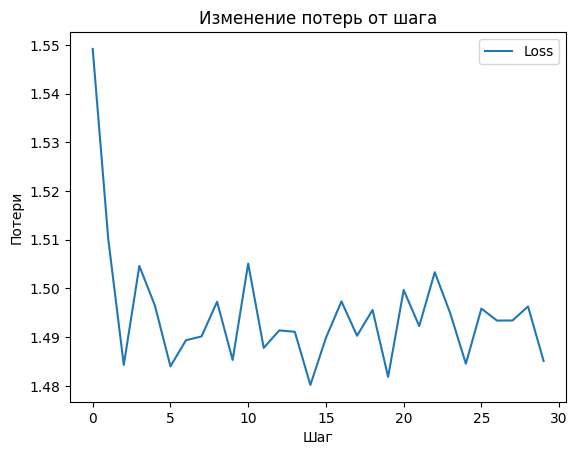

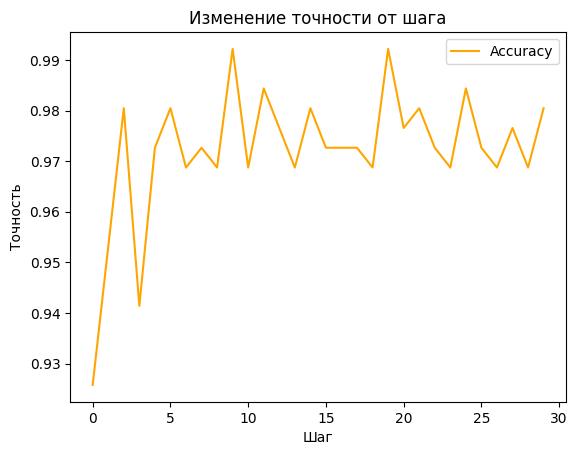

In [233]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.title('Изменение потерь от шага')
plt.xlabel('Шаг')
plt.ylabel('Потери')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.title('Изменение точности от шага')
plt.xlabel('Шаг')
plt.ylabel('Точность')
plt.legend()
plt.show()


In [234]:
x_test = tf.cast(x_test, dtype=tf.float32)

test_accuracy = accuracy(neural_net(x_test), y_test)

print(f'Точность модели: {test_accuracy:.4f}')
predictions = neural_net(x_test)

test_accuracy = accuracy(predictions, y_test)

print(f'Точность на тестовом наборе данных: {test_accuracy:.4f}')

Точность модели: 0.9637
Точность на тестовом наборе данных: 0.9637


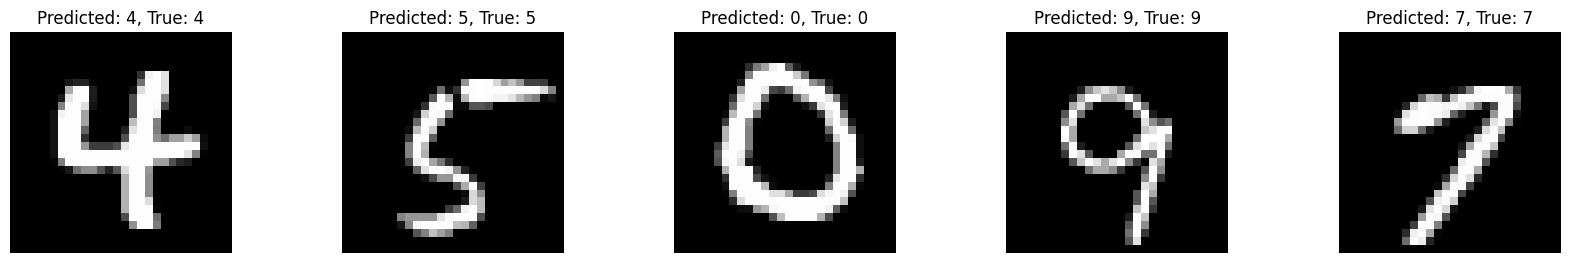

Количество угаданных: 5, количество ошибочных: 0


In [235]:
import random
import matplotlib.pyplot as plt

num_images_to_show = 5

random_indices = random.sample(range(len(x_test)), num_images_to_show)
images_to_show = tf.gather(x_test, random_indices)
labels_to_show = tf.gather(y_test, random_indices)

predictions = neural_net(images_to_show)

plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.5)
correct_predictions = 0
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    if tf.argmax(predictions[i], axis=0) == tf.cast(labels_to_show[i], tf.int64):
        plt.imshow(images_to_show[i].numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, True: {labels_to_show[i].numpy()}')
        correct_predictions += 1
    else:
        plt.imshow(images_to_show[i].numpy().reshape(28, 28), cmap='Reds')
        plt.title(f'Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, True: {labels_to_show[i].numpy()} (Incorrect)')
    plt.axis('off')

plt.show()


print(f'Количество угаданных: {correct_predictions}, количество ошибочных: {num_images_to_show - correct_predictions}')
